In [1]:
from preprocessing import Preproc
import pandas as pd
import numpy as np
from modelos import train_lstm





In [2]:
import time

In [3]:

series = ['airline']
for serie in series:
    path_serie = f'/home/eraylson/union/timeseries/{serie}.txt'
    df_serie = pd.read_csv(path_serie, header=None)
    pre = Preproc()
    serie_np = df_serie.to_numpy().reshape(-1, )
    dict_samples = pre.split_serie(serie_np, perc_train = 0.5, perc_val=0.25)
    train, val, test = dict_samples['train'], dict_samples['val'],  dict_samples['test']
    _ = pre.normalise_interval(train)
    train_norm = pre.normalise_interval(train)
    val_norm = pre.normalise_interval(val)
    test_norm = pre.normalise_interval(test)
    idx_lags = pre.select_lag_acf( train_norm, 20)
    X_train, y_train = pre.create_windows(train_norm, np.max(idx_lags)+1)

    qtd_lags = np.max(idx_lags)

    val_with_previous = np.vstack([train_norm[-qtd_lags-1:], val_norm])
    X_val, y_val = pre.create_windows(val_with_previous, np.max(idx_lags)+1)

    test_with_previous = np.vstack([val_norm[-qtd_lags-1:], test_norm])
    X_test, y_test = pre.create_windows(test_with_previous, np.max(idx_lags)+1)
    
    X_train = X_train[:, idx_lags]
    X_val = X_val[:, idx_lags]
    X_test = X_test[:, idx_lags]

    start = time.time()
    model, _ = train_lstm(X_train, y_train, X_val, y_val)
    duration = time.time() - start
    print(duration)

#6.1s

LAGS [0, 1, 2, 3, 4]


2024-01-06 13:58:51.034699: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-06 13:58:51.035222: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2/2 [==============================] - 0s 4ms/step
261.0222945213318


In [6]:
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_prev = model.predict(testX)
previsao = []
for i in range(0, len(y_prev)):
    previsao.append(abs(y_prev[i][0]))

2/2 [==============================] - 0s 17ms/step


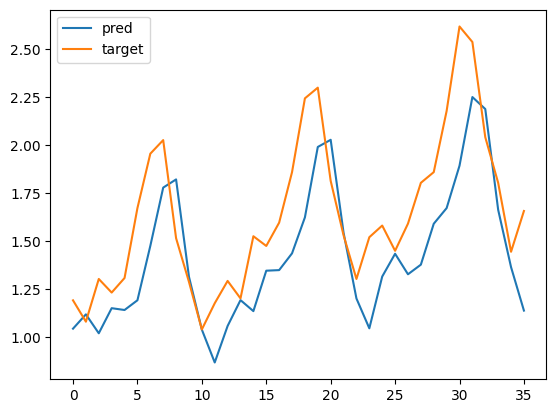

In [7]:
import matplotlib.pyplot as plt 
plt.plot(previsao, label = 'pred')
plt.plot(y_test, label = 'target')
plt.legend()
plt.show()